<a href="https://colab.research.google.com/github/take2rohit/denoising_autoencoder/blob/master/colab_denoising_ae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import dataset,libraries and mount colab 

In [1]:
__author__ = "Rohit Lal"
__copyright__ = "Copyright (C) 2020 Rohit Lal"
__license__ = "MIT"
__version__ = "1.0"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!git clone https://github.com/take2rohit/denoising_autoencoder.git # clone the code

Cloning into 'denoising_autoencoder'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 8773 (delta 2), reused 0 (delta 0), pack-reused 8764
Receiving objects: 100% (8773/8773), 68.34 MiB | 12.91 MiB/s, done.
Resolving deltas: 100% (75/75), done.


In [4]:
!mv denoising_autoencoder/* /content/ 

In [5]:
!git clone https://github.com/ruphan/Origami-Dataset.git # clone the datasets

Cloning into 'Origami-Dataset'...
remote: Enumerating objects: 2428, done.
remote: Counting objects: 100% (2428/2428), done.
remote: Compressing objects: 100% (2423/2423), done.
remote: Total 14654 (delta 6), reused 2427 (delta 5), pack-reused 12226
Receiving objects: 100% (14654/14654), 106.73 MiB | 22.92 MiB/s, done.
Resolving deltas: 100% (7/7), done.
Checking out files: 100% (14608/14608), done.


In [6]:
%matplotlib inline
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

import torchvision
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np,os

## The classes imported below are used for dataloader, transformation and model

from DAE_dataset_helper import OrigamiDatasetGenerate,ValidationGenerate
from DAE_dataset_helper import ToTensor,Resize, Normalize,AddNoise,RandomBackground
from DAE_dataset_helper import ToTensorValidate,NormalizeValidate,ResizeValidate
from DAE_model import AugmentedAutoencoder # contains various models to be tested on 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(device=device))

Tesla T4


# Divide Dataset into train and test
- specify location of dataset `origami_dataset_dir` (downloaded from github)
- set `inp` and `out` as input to network image and output segmentation map (reconstructed results) respectively.


In [7]:
train_batch_size = 32
test_batch_size = 32
split_percent = 0.9

origami_dataset_dir = "/content/Origami-Dataset/HapticOrigami/Fold_0.3"
random_background_dir = '/content/Origami-Dataset/BackgroundImages'
# origami_dataset_dir = "/content/MarowDataset"
inp='Input'
out='Output'

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

trns = transforms.Compose([Resize((128,128)),RandomBackground(random_background_dir)
                           ,AddNoise(0,0.005,noise_typ= 'gauss'),Normalize(),ToTensor()])
origami = OrigamiDatasetGenerate(root_dir=origami_dataset_dir,inp=inp, out=out, transform=trns)
train_size = int(split_percent * len(origami))
test_size = abs(len(origami) - train_size)
train_dataset, test_dataset = torch.utils.data.random_split(origami, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=train_batch_size,
                            shuffle=True,**kwargs)

test_loader = DataLoader(test_dataset, batch_size=test_batch_size,
                            shuffle=True,**kwargs)

print(f'Training dataset size: {len(train_dataset)} \
       Testing dataset size: {len(test_dataset)}')

Training dataset size: 540        Testing dataset size: 60


# Check your Dataset 
## Remeber the below cell consumes precious GPU if used in notebook. 
Its better not run this part when u r planning to train

Input to network


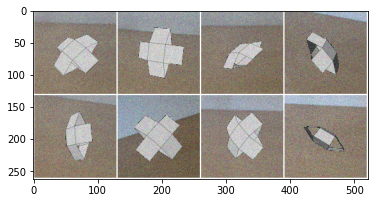

Output of network (To be verified with)


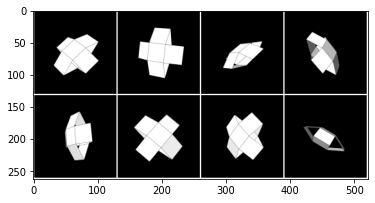

In [8]:
iterator = iter(train_loader)
sample = iterator.next()
augmented,original = sample['augmented'],sample['original']

def imshow(img, images_show = 8):
    kwargs =  {'nrow':4, "padding":2, "pad_value":1}
    img = torchvision.utils.make_grid(img[:images_show,:], **kwargs)
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg)
    plt.show()

print('Input to network')
imshow(augmented)
print('Output of network (To be verified with)')
imshow(original)

# Functions of training and testing of model

In [ ]:
def train(model, device, train_loader, optimizer, epoch,log_interval=20):
    global store_train_loss

    model.train()
    l2 = nn.MSELoss()
    for batch_idx, sample in enumerate(train_loader):
        data, target = sample['augmented'],sample['original']
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = l2(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch,loss.item()))
    store_train_loss.append([epoch,loss.item()])
    # scheduler.step()

def test(model, device, test_loader,save_img=False,ep=None,save_folder=None):
    model.eval()
    global store_test_loss 
    l2 = nn.MSELoss()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for c, sample in enumerate(test_loader):
            data, target = sample['augmented'],sample['original']
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += l2(output,target) # sum up batch loss
    test_loss /= max(1,c)
    
    print('\nTest set: Average loss: {:.4f}\n'.format(test_loss))
    store_test_loss.append([ep,(test_loss).item()])
    if save_img:
        kwargs =  {'nrow':4, "padding":2, "pad_value":1}
        images_show = 8
        op = output[:images_show,:].cpu()
        # torchvision.utils.save_image(op,f'{ep}_re.png', **kwargs)
        tar = data[:images_show,:].cpu()
        # torchvision.utils.save_image(tar, f'{ep}_in.png',**kwargs)
        cat = torch.cat((op,tar),dim=0)
        torchvision.utils.save_image(cat, os.path.join(save_folder, f'{ep}_in.png'),**kwargs)
        print('image saved')

def loss_plotter(store_train_loss, store_test_loss, epoch, location):
    store_train_loss= np.array(store_train_loss)
    store_test_loss= np.array(store_test_loss)
    plt.plot(store_train_loss[:,0], store_train_loss[:,1], label='Train Loss')
    plt.plot(store_test_loss[:,0], store_test_loss[:,1], label='Test Loss')
    plt.legend()
    plt.savefig(os.path.join(location,'plots',f'plot_{epoch}.png'))
    plt.show()

# Start Training Here
> The only variable u need to change is `root`. The code will handle foler creations

- Intermediate plots are saved in `root/plots/plot_{epoch}.png`
- Models are saved in `root/save_model_name.pt`
- Intermediate reconstructions are saved at `root`

*Remeber to delete old plots and saved results to avoid confusions between previously and recently trained*

In [ ]:
epochs = 2000
save_model_and_losses = True
load_saved_model = True
save_after = 50 #epocs (saves model and graphs)

root = '/content/drive/My Drive/RohitEeChianNUSTeleinternGamitrack/denoising_ae_colab/haptic_3_bg_noise'
save_model_name = "fold_3_bg_n.pt"
model = AugmentedAutoencoder().to(device)

### Create folders if not exists
saved_model_pth = os.path.join(os.path.join(root,save_model_name))
if not os.path.exists(root):
    os.mkdir(root)

if os.path.exists(saved_model_pth) and load_saved_model:
    model.load_state_dict(torch.load(saved_model_pth))
    print("MODEL loaded")

if not os.path.exists(os.path.join(root,'plots')):
    os.mkdir(os.path.join(root,'plots'))

### Start training here

optimizer = optim.Adam(model.parameters(), lr=1e-5)
# scheduler = StepLR(optimizer, step_size=10, gamma=0.7)
store_train_loss = []
store_test_loss = []

for epoch in tqdm(range(1, epochs + 1), unit='epochs'):
    train(model, device, train_loader, optimizer, epoch)

    if epoch % save_after ==0:
        test(model, device, test_loader,save_img=True, ep = epoch, save_folder=root)
        
        if save_model_and_losses:
            torch.save(model.state_dict(), saved_model_pth)

            np.save(os.path.join(root,'plots','train_losss.npy')
                        , store_train_loss)
            
            np.save(os.path.join(root,'plots','test_losss.npy')
                        , store_test_loss)
            
            loss_plotter(store_train_loss, store_test_loss,epoch,root)
            print('Model and Loss Saved!')
    print('\n')

# Validate with your own Image

In [9]:
def cross_validation(model, device, test_loader,ep = None, viewer=True, save_folder =None):
    model.eval()
    test_loss = 0
    correct = 0
    images_show = 8
    kwargs =  {'nrow':4, "padding":2, "pad_value":1}

    with torch.no_grad():
        validator = iter(test_loader)
        sample = next(validator)
        sample = sample.to(device).float()
        
        output = model(sample)
        encodings = model.encoder_op(sample)
        op = output[:images_show,:].cpu()
        tar = sample[:images_show,:].cpu()

    if viewer:
        print('Reconstructed')
        imshow(torchvision.utils.make_grid(op,**kwargs))
        print('Input to Netowrk')
        tar = sample[:images_show,:].cpu()
        imshow(torchvision.utils.make_grid(tar, **kwargs))  
    
    if save_folder is not None:
        cat = torch.cat((op,tar),dim=0)
        torchvision.utils.save_image(cat, os.path.join(save_folder,'validate_res.jpg'),**kwargs)
        
    return sample, output, encodings

def imshow(img, images_show = 8,ret_grid = False):
    kwargs =  {'nrow':4, "padding":2, "pad_value":1}
    img = torchvision.utils.make_grid(img[:images_show,:], **kwargs)
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    if ret_grid:
        return npimg
    plt.imshow(npimg)
    plt.show()

def generate_encoding_table(model, device, train_loader):
    model.eval()
    table = {}
    with torch.no_grad():
        for batch_idx, sample in enumerate(train_loader):
            # print(f"Processing batch: {batch_idx}/{len(train_loader)}")
            data, target = sample['augmented'],sample['original']
            data, target = data.to(device), target.to(device)
            # output = model(data)
            encodings = model.encoder_op(target)
            for i in range(len(encodings)):
                table[target[i,:,:,:].cpu()] = encodings[i,:].cpu()          
            # kwargs =  {'nrow':4, "padding":2, "pad_value":1}
            # for img, encoding in table.items():
            #     imshow(torchvision.utils.make_grid(img, **kwargs))   
    print("Table Generated!")
    return table


def top_n_similar_result(table, real_img_enc,real_img,reconstructed_real_img, n = 5, viewer=False):
    kwargs = {'nrow':4, "padding":2, "pad_value":1}
    loss = nn.MSELoss()
    real_img_enc = real_img_enc.cpu()
    max_similarity = -2.0
    enc_to_img = {}
    
    for table_img, table_encoding in table.items():
        similarity = F.conv2d(reconstructed_real_img.unsqueeze(0),
                              table_img.unsqueeze(0)).squeeze()
        enc_to_img[(similarity)] = table_img.unsqueeze(0)
        # print(similarity)

    sorted_encodings = sorted(enc_to_img.keys())
    most_similar_img = real_img.unsqueeze(0)
    most_similar_img = torch.cat((most_similar_img, 
                                  reconstructed_real_img.unsqueeze(0)),dim=0)
    for i in range(1,n+1):  
        most_similar_img = torch.cat((most_similar_img, enc_to_img[sorted_encodings[-i]]),dim=0)
    most_similar_img = imshow(torchvision.utils.make_grid(most_similar_img, **kwargs), ret_grid = True) 
    return  torch.tensor(most_similar_img), sorted_encodings[-1]

## Load validation Images

- Load dataset which only consists of real images and just change the folder in variable `origami_test_dir`
- change `root` path to save your validation results or to load previously trained model

Reconstructed


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


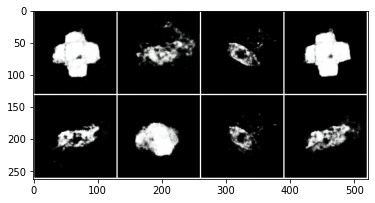

Input to Netowrk


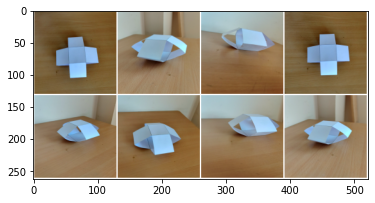

Table Generated!
Table has:  540 entries


In [10]:
origami_validate_dir = "/content/Origami-Dataset/HapticOrigami/Fold_0.3/Test"

## Loading and inferening model
root = '/content/drive/My Drive/RohitEeChianNUSTeleinternGamitrack/denoising_ae_colab/haptic_3_bg_noise'
save_model_name = "fold_3_bg_n.pt"

val_batch_size = 10
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

trns = transforms.Compose([ResizeValidate((128,128)), NormalizeValidate(),ToTensorValidate() ])
validator = ValidationGenerate(root_dir=origami_validate_dir, transform=trns)
val_loader = DataLoader(validator, batch_size=val_batch_size,
                            shuffle=True,**kwargs)


saved_model_pth = os.path.join(root,save_model_name)
if not os.path.exists(saved_model_pth):
    print('saved file not found!')

val_img_save_folder = os.path.join(os.path.join(root,'validation_results'))
if not os.path.exists(val_img_save_folder):
    os.mkdir(val_img_save_folder)

model = AugmentedAutoencoder().to(device)
# summary(model,(3,128,128))
model.load_state_dict(torch.load(saved_model_pth))
sample, output, encodings = cross_validation(model, device, val_loader,
                                             save_folder = val_img_save_folder)
table = generate_encoding_table(model, device, train_loader)

print('Table has: ', len(table.keys()), 'entries')

Top 4 most similar images 

Display Order: Input Image -> Recontructed Image -> Top n image
Maximum similarity: 8849.314453125


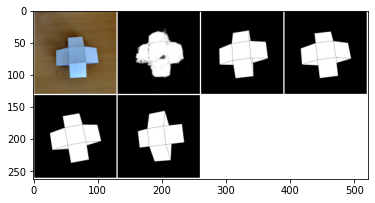

Maximum similarity: 2684.00390625


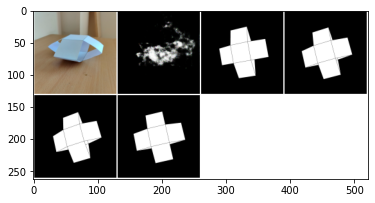

Maximum similarity: 1512.9095458984375


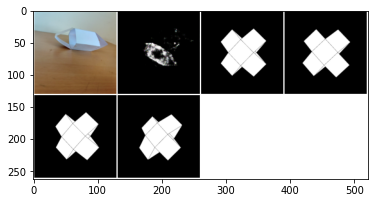

Maximum similarity: 8722.73828125


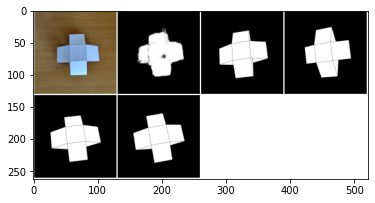

Maximum similarity: 2801.454833984375


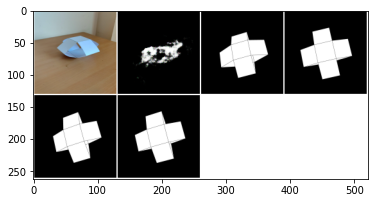

Maximum similarity: 6206.09228515625


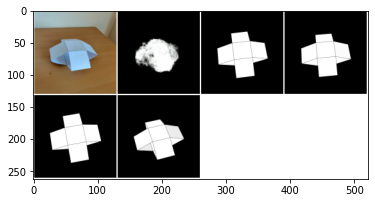

Maximum similarity: 1340.7681884765625


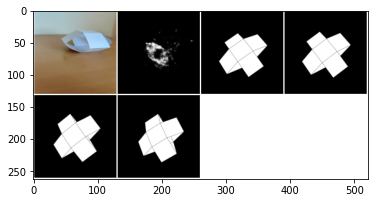

In [11]:
top_n = 4
print(f'Top {top_n} most similar images \n')
print(f'Display Order: Input Image -> Recontructed Image -> Top n image')
for i in range(7):
    real_img = sample[i,:].cpu()
    reconstructed_real_img = output[i,:].cpu()
    real_img_enc = encodings[i,:]
    most_similar_img, max_similarity = top_n_similar_result(table, real_img_enc,real_img,
                                                            reconstructed_real_img, n = top_n)
    print(f'Maximum similarity: {max_similarity}')

    plt.imshow(most_similar_img)
    plt.show()